In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score

%matplotlib inline

# Обработка данных

## Получение данных

In [102]:
df = pd.read_csv('Исходные данные.csv', sep=';',
                 error_bad_lines=False,
                 parse_dates=['DT'],
                 decimal=',', index_col=['Unnamed: 0'])
print(df.shape)
df.head()

(7041, 84)


,nplv,DT,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),N2 (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,произв количество плавок,произв количество плавок (цел),расход газ Ar,расход газ N2,расход C пров.,сыпуч известь РП,сыпуч кварцит,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь (сух.),сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeMo,ферспл FeSi-75,ферспл FeV азот.,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл Ni H1 пласт.,ферспл SiMn18,...,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,г6837?3<87?,2070-06-21 00:14:00,Э76ХФ,Р65,29.0,45.366667,24.400000,41.033333,NaN,0.456460,0.059572,0.117446,0.104762,0.040938,1557.0,1580.0,13.606742,NaN,12809.016393,115.5,1.0,1.0,1.0,18.611,NaN,NaN,NaN,NaN,0.170,NaN,0.401,0.123,0.02,NaN,NaN,NaN,0.051939,0.112,NaN,0.182,...,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.003,0.756,0.0001,0.417,0.126,0.779,0.009,0.012,0.086,0.011,0.018,0.559,0.003,0.037,NaN,63.7,1.1,3.7,0.12,2.6,NaN,NaN,53.4,1.0,5.8,0.15,2.6,NaN
1,г683863<886,2070-06-21 01:07:00,Э76ХФ,Р65,26.0,44.066667,13.866667,44.066667,NaN,0.359285,0.083738,0.160923,0.110327,0.040083,1601.0,1591.0,8.074721,NaN,12816.346154,111.6,1.0,1.0,1.0,11.659,NaN,NaN,NaN,NaN,0.488,NaN,NaN,0.094,0.02,NaN,NaN,NaN,0.050854,0.102,NaN,0.251,...,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.003,0.774,0.0003,0.416,0.109,0.767,0.008,0.013,0.079,0.008,0.021,0.543,0.003,0.038,NaN,58.5,0.8,4.9,0.14,2.2,NaN,NaN,59.3,0.6,4.1,0.11,2.3,NaN
2,г683863<887,2070-06-21 02:00:00,Э76ХФ,Р65,24.0,43.350000,17.950000,43.350000,NaN,0.331665,0.081490,0.132332,0.139860,0.041622,1593.0,1586.0,13.801968,NaN,12511.420613,115.8,1.0,1.0,1.0,19.871,NaN,NaN,NaN,NaN,0.050,NaN,0.346,0.061,0.02,NaN,NaN,NaN,0.052807,0.160,NaN,0.204,...,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.004,0.770,0.0009,0.417,0.108,0.788,0.006,0.012,0.078,0.008,0.013,0.568,0.003,0.038,NaN,58.0,0.8,8.6,0.12,2.6,NaN,NaN,57.2,0.5,8.1,0.13,2.3,NaN
3,г683863<888,2070-06-21 02:58:00,Э76ХФ,Р65,17.0,46.183333,19.816667,46.183333,NaN,0.377945,0.133194,0.221605,0.165186,0.042050,1589.0,1589.0,12.664959,NaN,12998.149706,116.3,1.0,1.0,1.0,19.497,NaN,NaN,0.077,NaN,0.050,NaN,0.390,0.059,0.02,NaN,NaN,NaN,0.053349,0.161,NaN,0.345,...,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.003,0.767,0.0002,0.419,0.103,0.795,0.008,0.013,0.070,0.007,0.014,0.571,0.003,0.038,NaN,59.8,0.4,6.4,0.11,2.4,NaN,NaN,60.3,0.5,6.3,0.12,2.6,NaN
4,г683863<889,2070-06-21 03:50:00,Э76ХФ,Р65,20.0,48.500000,17.033333,48.500000,NaN,0.389875,0.105094,0.169459,0.143024,0.040967,1597.0,1592.0,10.298350,NaN,12987.475538,115.0,1.0,1.0,1.0,16.649,NaN,NaN,0.082,NaN,0.050,NaN,0.412,0.035,0.02,NaN,NaN,NaN,0.051975,0.149,NaN,0.263,...,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.003,0.784,0.0003,0.421,0.105,0.796,0.006,0.013,0.081,0.008,0.017,0.568,0.003,0.037,NaN,59.6,0.7,4.7,0.12,2.4,NaN,NaN,60.3,0.6,4.5,0.09,2.5,NaN


In [103]:
for col in df.select_dtypes(['float64', 'int64']).columns:
  df[col] = df[col].astype('float64')

## Выделяем целевые переменные

In [104]:
target_col = ['химшлак последний Al2O3', 'химшлак последний CaO', 'химшлак последний R', 'химшлак последний SiO2']
target_df = df[target_col]
target_df.head()

,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
0,NaN,53.4,2.6,NaN
1,NaN,59.3,2.3,NaN
2,NaN,57.2,2.3,NaN
3,NaN,60.3,2.6,NaN
4,NaN,60.3,2.5,NaN


In [105]:
df.drop(target_col, axis = 1, inplace = True)

## Обработка пропущенных значений

                               empty
ферспл FeSi-75              0.999290
сыпуч  кокс. мелочь (сух.)  0.999006
сыпуч кварцит               0.998154
ферспл FeMo                 0.995313
ферспл  Ni H1 пласт.        0.988354


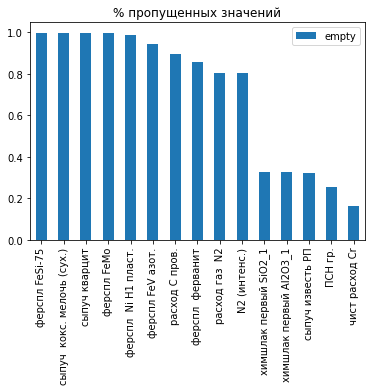

In [106]:
empty_values = pd.DataFrame(df.apply(lambda x: x.isna().sum()/df.shape[0]).sort_values(ascending = False),
                            columns = ['empty'])
print(empty_values.head())
empty_values.head(15).plot(kind = 'bar', title = '% пропущенных значений')

In [107]:
#удалим колонки >80% пропущенных значений

drop_empty_col = empty_values[empty_values['empty'] > 0.8].index
drop_empty_col

Index(['ферспл FeSi-75', 'сыпуч  кокс. мелочь (сух.)', 'сыпуч кварцит',
       'ферспл FeMo', 'ферспл  Ni H1 пласт.', 'ферспл FeV азот.',
       'расход C пров.', 'ферспл  ферванит', 'расход газ  N2', 'N2 (интенс.)'],
      dtype='object')

In [108]:
df.drop(drop_empty_col, axis = 1, inplace = True)

## Обработка уникальных значений

In [109]:
uniq_value = df.apply(lambda x: len(x.unique())).sort_values()
uniq_value.head()

произв  количество плавок         2
произв количество плавок (цел)    2
произв количество обработок       4
химсталь последний Ti             6
ферспл CaC2                       7
dtype: int64

In [110]:
[(col, df[col].unique()) for col in uniq_value.index[:5]]

[('произв  количество плавок', array([ 1., nan])),
 ('произв количество плавок (цел)', array([ 1., nan])),
 ('произв количество обработок', array([ 1., nan,  2.,  3.])),
 ('химсталь последний Ti', array([0.003,   nan, 0.002, 0.004, 0.001, 0.005])),
 ('ферспл CaC2',
  array([0.02     ,       nan, 0.03     , 0.05     , 0.0200001, 0.04     ,
         0.01     ]))]

In [111]:
# удаляем колонки, где только 1 уникальное значение, не считая nan

df.drop(uniq_value.index[:2], axis = 1, inplace = True)

## обработка выбросов

In [112]:
def confidence_interval(col, rate = 0.95) -> tuple:
  """
  col - column of dataframe
  rate - degree of trust
  return: confidence_interval (start, end)
  """
  return st.t.interval(rate, col.shape[0] - 1, loc=col.mean())


def processing_emissions(col, rate = 0.25) -> list:
  quan_low = col.quantile(rate)
  quan_big = col.quantile(1-rate)
  razmax = quan_big - quan_low
  val_low = col[col <= quan_low - 1.5*razmax].values
  val_big = col[col >= quan_big + 1.5*razmax].values
  col.replace(val_low, quan_low, inplace = True)
  col.replace(val_big, quan_big, inplace = True)

  min, max = confidence_interval(col)
  val_low = col[col <= min].values
  val_big = col[col >= max].values
  col.replace(val_low, min, inplace = True)
  col.replace(val_big, max, inplace = True)

  return col.astype('float64')

In [113]:
rate = 0.01

for col in df.select_dtypes(['int64', 'float64']).columns:
  df[col] = processing_emissions(df[col], rate)

## Замена пропущенных значений

In [114]:
chem_col = [col for col in df.columns if 'хим' in col]

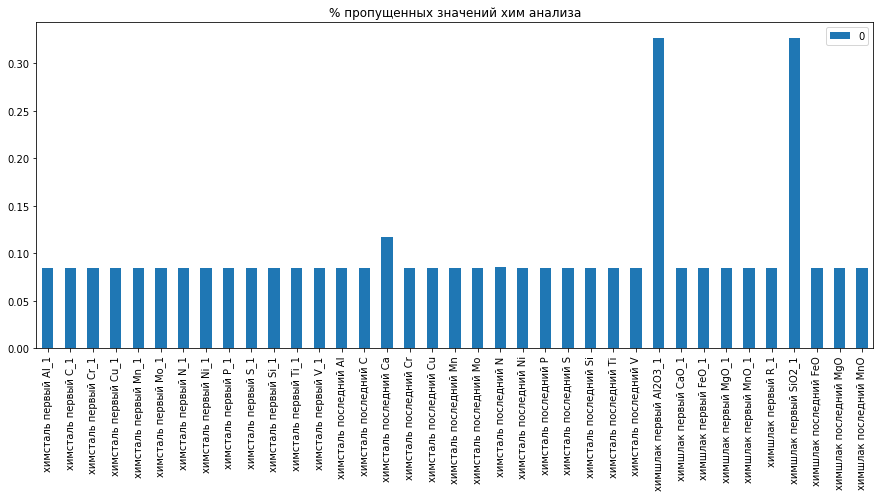

In [115]:
# Смотрим на % пропущенных значений
pd.DataFrame([empty_values.loc[col].values for col in df.columns if 'хим' in col],
             index =chem_col).plot(kind = 'bar',
                                   title = '% пропущенных значений хим анализа', figsize = (15,6))


In [116]:
# заменяем пропущенные значения на 0 (по заданию)
[df[col].fillna(0, inplace = True) for col in df.columns if 'хим' in col]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [117]:
# проверяем
df.apply(lambda x: x.isna().sum()/df.shape[0]).sort_values(ascending = False).loc[chem_col]

химсталь первый Al_1      0.0
химсталь первый C_1       0.0
химсталь первый Cr_1      0.0
химсталь первый Cu_1      0.0
химсталь первый Mn_1      0.0
химсталь первый Mo_1      0.0
химсталь первый N_1       0.0
химсталь первый Ni_1      0.0
химсталь первый P_1       0.0
химсталь первый S_1       0.0
химсталь первый Si_1      0.0
химсталь первый Ti_1      0.0
химсталь первый V_1       0.0
химсталь последний Al     0.0
химсталь последний C      0.0
химсталь последний Ca     0.0
химсталь последний Cr     0.0
химсталь последний Cu     0.0
химсталь последний Mn     0.0
химсталь последний Mo     0.0
химсталь последний N      0.0
химсталь последний Ni     0.0
химсталь последний P      0.0
химсталь последний S      0.0
химсталь последний Si     0.0
химсталь последний Ti     0.0
химсталь последний V      0.0
химшлак первый Al2O3_1    0.0
химшлак первый CaO_1      0.0
химшлак первый FeO_1      0.0
химшлак первый MgO_1      0.0
химшлак первый MnO_1      0.0
химшлак первый R_1        0.0
химшлак пе

In [118]:
# Смотрим на все типы данных
set(df.dtypes)

{dtype('float64'), dtype('<M8[ns]'), dtype('O')}

In [119]:
# Смотрим на категориальные переменные
df.select_dtypes('O').isna().sum()

nplv       0
МАРКА      0
ПРОФИЛЬ    0
dtype: int64

In [120]:
# Смотрим на дату
df.select_dtypes('<M8[ns]').isna().sum()

DT    0
dtype: int64

In [121]:
for col in df.select_dtypes('float64'):
  df[col] = df[col].fillna(df[col].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


In [ ]:
# проверяем
df.info()

## Визуализация данных

In [123]:
# for col in df.select_dtypes(['int64', 'float64']):
#   print(df[[col]].boxplot())
#   plt.title(col)
#   plt.show()

## Завершающая обработка данных

In [124]:
uniq_value = df.apply(lambda x: len(x.unique())).sort_values()
uniq_value.head()

произв количество обработок    1
ферспл CaC2                    2
химсталь последний Ti          6
химсталь первый Ti_1           6
температура последняя          6
dtype: int64

In [125]:
[(col, df[col].unique()) for col in uniq_value.index[:5]]

[('произв количество обработок', array([1.])),
 ('ферспл CaC2', array([0.02, 0.02])),
 ('химсталь последний Ti', array([0.003, 0.   , 0.002, 0.004, 0.001, 0.005])),
 ('химсталь первый Ti_1', array([0.002, 0.001, 0.   , 0.003, 0.004, 0.005])),
 ('температура последняя',
  array([1586.05492584, 1589.97552786, 1589.        , 1587.60839425,
         1587.        , 1588.        ]))]

In [126]:
# можем удалить одну колонку 
df.drop(['произв количество обработок'], axis = 1, inplace = True)

In [127]:
# удалим также колонку с датой и nplv так как не наблюдается взимосвязь с исходной задачей
df.drop(['DT', 'nplv'], axis = 1, inplace = True)

# Выбор данных

## Опредление необходимой выборки

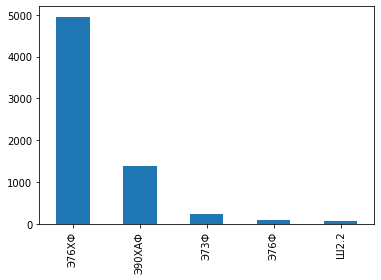

In [128]:
df['МАРКА'].value_counts()[:5].plot(kind = 'bar')

In [129]:
for col in target_df.columns:
  df[col] = target_df[col]

In [130]:
data = df.copy()
#data = data[data['МАРКА'] == 'Э76ХФ']
#data.drop(['МАРКА'], axis = 1, inplace = True)
print(data.shape)
data.head()

(7041, 69)


,МАРКА,ПРОФИЛЬ,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,расход газ Ar,сыпуч известь РП,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,химсталь последний Mn,химсталь последний Mo,химсталь последний N,химсталь последний Ni,химсталь последний P,химсталь последний S,химсталь последний Si,химсталь последний Ti,химсталь последний V,химшлак первый Al2O3_1,химшлак первый CaO_1,химшлак первый FeO_1,химшлак первый MgO_1,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2
0,Э76ХФ,Р65,28.452542,45.366667,22.970824,43.799966,2.999965,0.456460,0.059572,0.117446,0.104762,0.040938,1565.851073,1586.054926,13.553562,12979.975121,115.500000,17.410829,0.132179,0.170,0.401000,0.123,0.02,0.051939,0.112,0.182,0.106,4559.196481,0.002,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.003,0.756,0.0001,0.417,0.126,0.779,0.009,0.012,0.086,0.011,0.018,0.559,0.003,0.037,0.0,56.488125,1.1,9.694673,0.12,2.6,0.0,1.0,7.101689,0.15,NaN,53.4,2.6,NaN
1,Э76ХФ,Р65,26.000000,44.066667,19.050222,44.066667,2.999965,0.359285,0.083738,0.160923,0.110327,0.040083,1569.771675,1589.975528,9.632960,12979.975121,112.435835,13.490227,0.132179,0.488,0.420162,0.094,0.02,0.050854,0.102,0.251,0.149,4555.275879,0.002,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.003,0.774,0.0003,0.416,0.109,0.767,0.008,0.013,0.079,0.008,0.021,0.543,0.003,0.038,0.0,56.488125,0.8,9.694673,0.14,2.2,0.0,0.6,7.101689,0.11,NaN,59.3,2.3,NaN
2,Э76ХФ,Р65,24.531940,43.937951,19.050222,43.799966,2.999965,0.331665,0.081490,0.132332,0.139860,0.041622,1569.771675,1586.054926,13.553562,12979.975121,115.800000,17.410829,0.132179,0.050,0.346000,0.061,0.02,0.052807,0.160,0.204,0.145,4555.275879,0.002,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.004,0.770,0.0009,0.417,0.108,0.788,0.006,0.012,0.078,0.008,0.013,0.568,0.003,0.038,0.0,56.488125,0.8,9.694673,0.12,2.6,0.0,0.5,8.100000,0.13,NaN,57.2,2.3,NaN
3,Э76ХФ,Р65,24.531940,46.183333,19.816667,46.183333,2.999965,0.377945,0.133194,0.221605,0.165186,0.042050,1569.771675,1589.000000,12.664959,12983.895723,116.300000,17.410829,0.077000,0.050,0.390000,0.059,0.02,0.053349,0.161,0.345,0.237,4555.275879,0.002,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.003,0.767,0.0002,0.419,0.103,0.795,0.008,0.013,0.070,0.007,0.014,0.571,0.003,0.038,0.0,56.488125,0.4,9.694673,0.11,2.4,0.0,0.5,7.101689,0.12,NaN,60.3,2.6,NaN
4,Э76ХФ,Р65,24.531940,47.858553,19.050222,47.720568,2.999965,0.389875,0.105094,0.169459,0.143024,0.040967,1569.771675,1589.975528,10.298350,12983.895723,115.000000,16.649000,0.082000,0.050,0.412000,0.035,0.02,0.051975,0.149,0.263,0.187,4555.275879,0.002,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.003,0.784,0.0003,0.421,0.105,0.796,0.006,0.013,0.081,0.008,0.017,0.568,0.003,0.037,0.0,56.488125,0.7,9.694673,0.12,2.4,0.0,0.6,7.101689,0.09,NaN,60.3,2.5,NaN


# Подготовка данных для построение моделей

## Нормализация данных

In [131]:
data.fillna(-1, inplace = True)

In [132]:
num_scaler = MinMaxScaler()

for col in data.select_dtypes(['float64']).columns:
  data[[col]] = num_scaler.fit_transform(data[[col]])

In [133]:
data['ПРОФИЛЬ'].value_counts()

Р65                                 6427
ОР65                                 221
60E1                                  95
Шар заг d шара 80-100 мм 2,3 гр.      59
Рельсы трамвайные                     56
UIC54                                 54
Р50                                   44
Шар заг d шара 80-100 мм 4 гр.        17
136 RE                                17
Шары мелющие d 80-100 мм              14
54E1                                  10
НЕТ                                    7
ОР50                                   6
Швеллер 40У                            6
Швеллер 40У (12 категория)             4
Шар заг d шара 100 мм 2 гр.            2
60E2                                   1
НЛЗ 300х365                            1
Name: ПРОФИЛЬ, dtype: int64

In [134]:
for col in pd.get_dummies(df['ПРОФИЛЬ']).columns:
  data[col] = pd.get_dummies(df['ПРОФИЛЬ'])[col]

In [135]:
for col in pd.get_dummies(df['МАРКА']).columns:
  data[col] = pd.get_dummies(df['МАРКА'])[col]

In [136]:
# удаляем столбец профиль
data.drop(['ПРОФИЛЬ'], axis = 1, inplace = True)
data.drop(['МАРКА'], axis = 1, inplace = True)

In [137]:
data.head()

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,температура первая,температура последняя,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,расход газ Ar,сыпуч известь РП,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь КМ1,сыпуч шпат плав.,ферспл CaC2,ферспл FeV-80,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,...,химшлак последний Al2O3,химшлак последний CaO,химшлак последний R,химшлак последний SiO2,136 RE,54E1,60E1,60E2,UIC54,НЕТ,НЛЗ 300х365,ОР50,ОР65,Р50,Р65,Рельсы трамвайные,Шар заг d шара 100 мм 2 гр.,"Шар заг d шара 80-100 мм 2,3 гр.",Шар заг d шара 80-100 мм 4 гр.,Шары мелющие d 80-100 мм,Швеллер 40У,Швеллер 40У (12 категория),09Г2С,900А,G2HH,R260,R350HT,НХ,С255,С345,С355,Ст3сп,Ш2.2,Ш2Л,Э73Ф,Э76,Э76Ф,Э76ХАФ,Э76ХФ,Э90ХАФ
0,1.000000,0.364412,1.000000,0.000000,0.498865,0.499569,0.188831,0.313225,0.202459,0.354618,0.0,0.000000,1.000000,0.0,0.781555,1.000000,0.177688,0.174672,0.403527,0.523585,1.0,0.398750,0.160796,0.295972,0.189531,1.0,0.4,0.477301,0.592593,0.709497,0.505935,0.333333,0.52381,0.569536,0.428571,0.489362,0.698630,0.4,0.2,0.214286,...,0.0,0.794161,0.878049,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.374448,0.032831,0.000000,0.068025,0.498865,0.392181,0.266175,0.429530,0.214323,0.346632,1.0,1.000000,0.000000,0.0,0.000000,0.000000,0.177688,0.521834,0.423405,0.386792,1.0,0.389776,0.145482,0.416813,0.267148,0.0,0.4,0.570552,0.555556,0.625698,0.477003,0.300000,0.52381,0.529801,0.333333,0.489362,0.701674,0.4,0.2,0.214286,...,0.0,0.880292,0.804878,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.000000,0.000000,0.000000,0.000000,0.498865,0.361659,0.258981,0.353047,0.277280,0.361008,1.0,0.000000,1.000000,0.0,0.858074,1.000000,0.177688,0.043668,0.346473,0.231132,1.0,0.405928,0.234303,0.334501,0.259928,0.0,0.4,0.629448,0.565217,0.597765,0.500000,0.233333,0.52381,0.516556,0.380952,0.404255,0.692542,0.4,0.2,0.285714,...,0.0,0.849635,0.804878,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.000000,0.572714,0.195492,0.607908,0.498865,0.412803,0.424461,0.591860,0.331270,0.364997,1.0,0.751179,0.773350,1.0,0.985605,1.000000,0.101788,0.043668,0.392116,0.221698,1.0,0.410411,0.235835,0.581436,0.425993,0.0,0.4,0.597546,0.499195,0.586592,0.453264,0.300000,0.52381,0.463576,0.285714,0.425532,0.660578,0.2,0.1,0.214286,...,0.0,0.894891,0.878049,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.000000,1.000000,0.000000,1.000000,0.498865,0.425986,0.334526,0.452365,0.284025,0.354884,1.0,1.000000,0.169716,1.0,0.654023,0.805686,0.108666,0.043668,0.414938,0.108491,1.0,0.399047,0.217458,0.437828,0.335740,0.0,0.4,0.565644,0.537842,0.586592,0.483680,0.233333,0.52381,0.529801,0.333333,0.425532,0.680365,0.2,0.2,0.214286,...,0.0,0.894891,0.853659,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [138]:
scaler_target_df = data[target_col]
data.drop(target_col, axis = 1, inplace = True)

In [152]:
mark_index = df[df['МАРКА'] == 'Э76ХФ'].index

df[df['МАРКА'] == 'Э76ХФ']['химшлак последний Al2O3'].isna()

0        True
1        True
2        True
3        True
4        True
        ...  
7022    False
7023    False
7024    False
7025    False
7026    False
Name: химшлак последний Al2O3, Length: 4953, dtype: bool

## Разбиение выборки на тренировочную, тестовую, валидационную

In [157]:
from feature_selector import FeatureSelector


def Check_Collinear(X,correlation_threshold= 0.9):
  """
    функция возвращает названия колонок, которые следует удалить из-за мультиколлинеарности

  """
  fs = FeatureSelector(data = X, labels = X.columns)
  fs.identify_collinear(correlation_threshold)
  collinear_features = fs.ops['collinear']
  cols=X.columns.drop(collinear_features)

  return X[cols]


def Corr_more_then_limit(X,y,limit=0.15):
  df=X.join(y)
  y_cor=df.corr()[y.name]
  cor = y_cor[abs(y_cor) > limit]
  #print("len before",len(X.columns))
  df=df[cor.index]
  X=df.drop(y.name,axis=1)
  #print("len after",len(X.columns))

  return X

In [158]:
def get_data(df, target, col):
  df[col] = target[col]
  test = df[df[col] == -1.0]         # где  нет значений
  value = df[df[col] != -1.0]        # где есть значения
  X = value.drop(col, axis = True)
  y = target[col]

  X=Corr_more_then_limit(X,y)
  X=Check_Collinear(X)

  X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.8, random_state=42)
  X_train, X_valid, y_train, y_valid = train_test_split(
  X_train, y_train, test_size=0.65, random_state=42)

  return  X_train, X_valid, X_test, y_train, y_valid, y_test, test 

In [180]:
def get_score(target, name, model, X_train, X_valid, X_test, y_train, y_valid, y_test, status):
  model.fit(X_train, y_train)
  score_train =model.score(X_train, y_train) 
  score_test = model.score(X_test, y_test)

  if status:
    df_new = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ['importance'])
    df_new[df_new['importance']>0].sort_values(by = 'importance').plot(kind = 'bar', title = f'{name} model and {target} columns')
    plt.show()

  cross_score = cross_val_score(model, X_valid, y_valid, cv=5)

  return score_train, score_test, cross_score

# Модели

## Тестирование моделей

In [160]:
mls = {
        'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0), 
        'linear': LinearRegression(), 'RandomForestRegressor':RandomForestRegressor(max_depth=2, random_state=0),
        'LassoCV': LassoCV(), 'Ridge': RidgeCV(), 'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
        }

16 features with a correlation magnitude greater than 0.90.



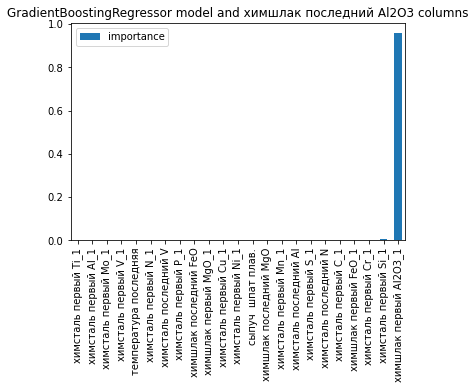

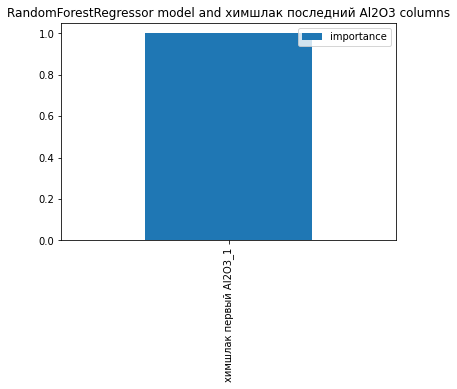

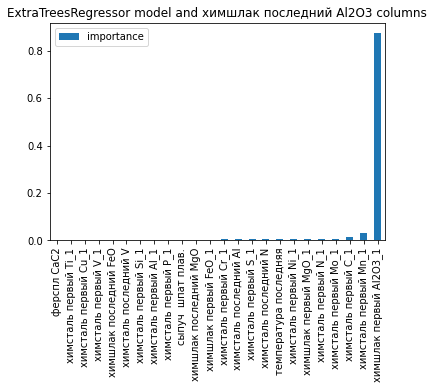

16 features with a correlation magnitude greater than 0.90.



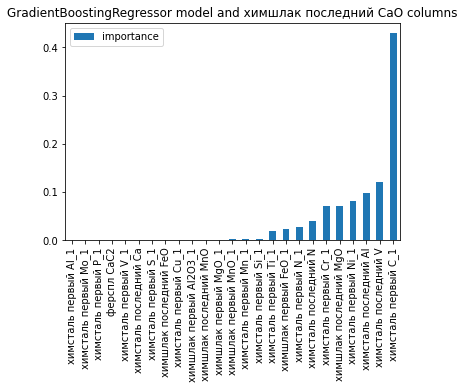

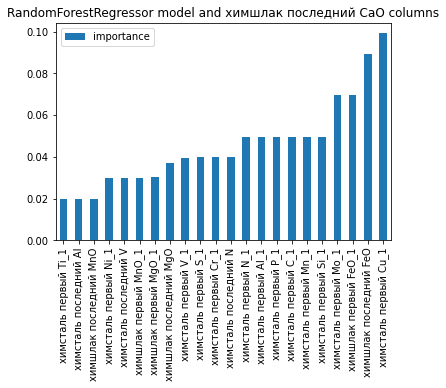

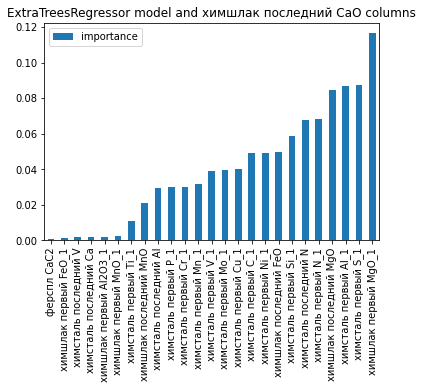

16 features with a correlation magnitude greater than 0.90.



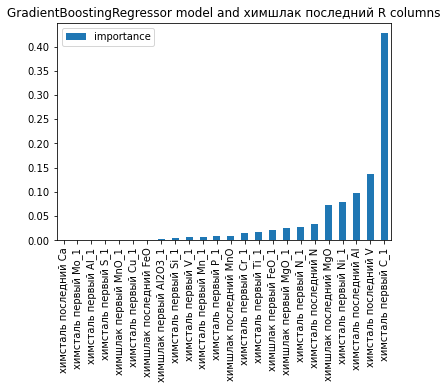

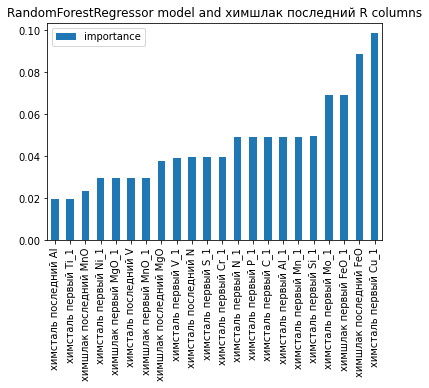

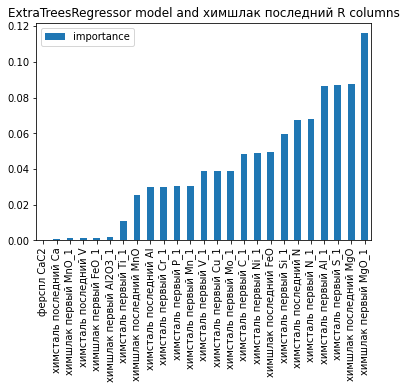

16 features with a correlation magnitude greater than 0.90.



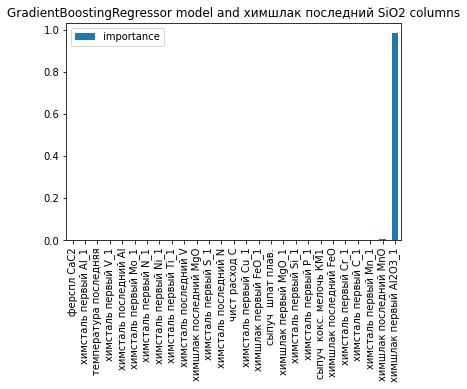

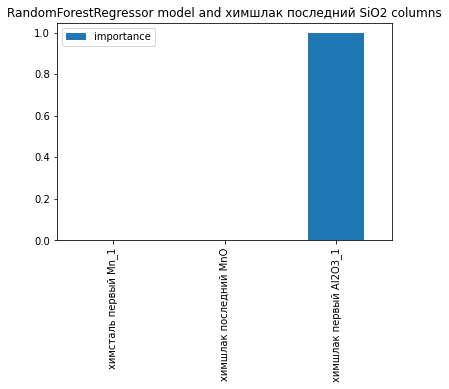

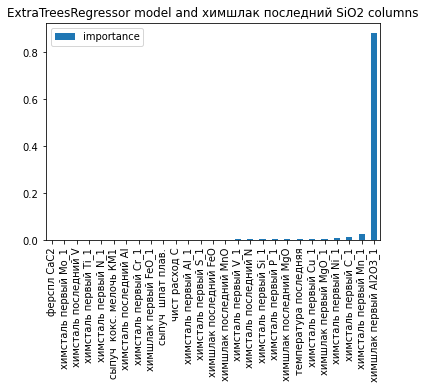

In [181]:
dict_results = {}
status = False

for col in target_col:
  X_train, X_valid, X_test, y_train, y_valid, y_test, test = get_data(data, scaler_target_df, col)
  dict_results[col] = {}
  for name, model in mls.items():
    if name not in ['linear', 'LassoCV', 'Ridge', 'ElasticNetCV']:
      status = True
    else:
      status = False

    results = get_score(col, name, model, X_train, X_valid, X_test, y_train, y_valid, y_test, status)
    dict_results[col][name] = {'score_train' : results[0].round(3),'score_test' : results[1].round(3),
                               'cross_score': results[2].mean().round(3)}

In [257]:
for k,v in dict_results.items():
  print(k)
  for ki,vi in v.items():
    print(ki, vi)
  print('-'*30)

химшлак последний Al2O3
GradientBoostingRegressor {'score_train': 0.986, 'score_test': 0.946, 'cross_score': 0.937}
linear {'score_train': 0.933, 'score_test': 0.924, 'cross_score': 0.915}
RandomForestRegressor {'score_train': 0.936, 'score_test': 0.942, 'cross_score': 0.934}
LassoCV {'score_train': 0.932, 'score_test': 0.929, 'cross_score': 0.914}
Ridge {'score_train': 0.931, 'score_test': 0.928, 'cross_score': 0.916}
ElasticNetCV {'score_train': 0.931, 'score_test': 0.929, 'cross_score': 0.914}
ExtraTreesRegressor {'score_train': 1.0, 'score_test': 0.95, 'cross_score': 0.943}
------------------------------
химшлак последний CaO
GradientBoostingRegressor {'score_train': 0.984, 'score_test': 0.956, 'cross_score': 0.956}
linear {'score_train': 0.945, 'score_test': 0.936, 'cross_score': 0.928}
RandomForestRegressor {'score_train': 0.958, 'score_test': 0.958, 'cross_score': 0.955}
LassoCV {'score_train': 0.944, 'score_test': 0.938, 'cross_score': 0.928}
Ridge {'score_train': 0.945, 'score

In [270]:
results = pd.DataFrame([(tk, kn, list(kv.items())[2][1]) for tk, tv in dict_results.items() for kn, kv in tv.items()], columns = ['name', 'model', 'score'])
results.groupby(['name']).max()

mls_best = []

for col in results['name'].unique():
  t = results[results['name'] == col].set_index('model')
  mls_best.append(t['score'].idxmax())
  print(t['score'].idxmax(), t['score'].max())


ExtraTreesRegressor 0.943
ExtraTreesRegressor 0.957
GradientBoostingRegressor 0.968
ExtraTreesRegressor 0.981


## Визуализация результатов

In [313]:
def get_info(name, model, X_train, y_train, X_test, y_test, col):
  model.fit(X_train, y_train)
  plt.figure(figsize=(15,5))
  popular_mark=data[data['Э76ХФ']==1]
  popular_mark_y=scaler_target_df[data['Э76ХФ']==1]
  predicted=model.predict(popular_mark.loc[1000:4000,X_train.columns])
  plt.scatter(np.arange(0,len(predicted)), predicted,color='red', label = 'predict')
  plt.scatter(np.arange(0,len(predicted)), popular_mark_y.loc[1000:4000,col],color='blue', label = 'real', alpha = 0.5)
  plt.legend()
  plt.title(col)

16 features with a correlation magnitude greater than 0.90.

16 features with a correlation magnitude greater than 0.90.

16 features with a correlation magnitude greater than 0.90.

16 features with a correlation magnitude greater than 0.90.



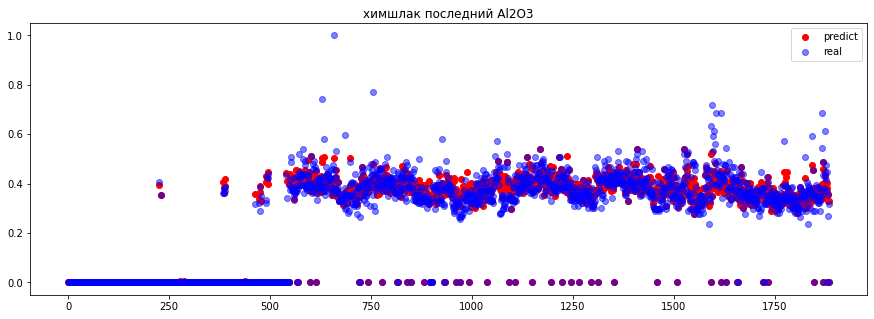

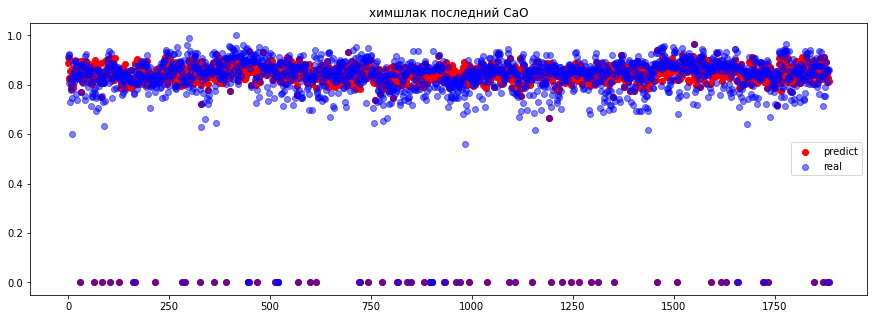

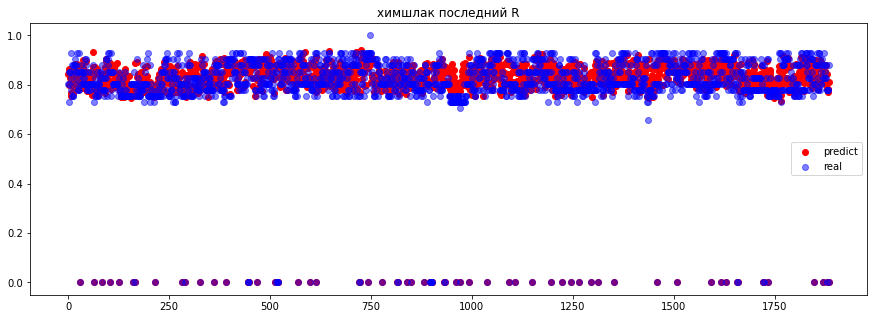

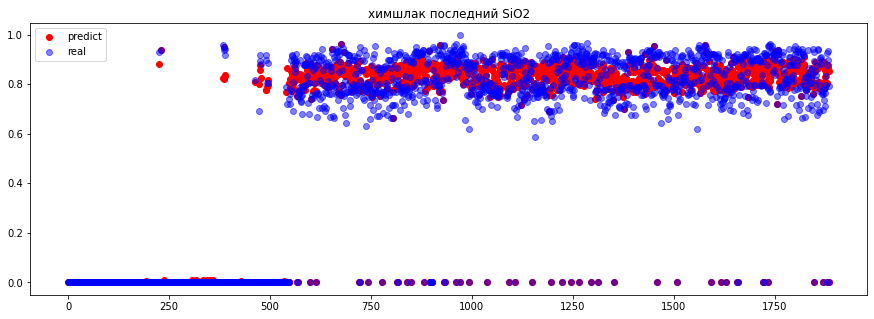

In [314]:
for ids, models in enumerate(mls_best):
  for id, (name, model) in enumerate(mls.items()):
    if name == models:
      X_train, X_valid, X_test, y_train, y_valid, y_test, test = get_data(data, scaler_target_df, target_col[ids])
      results = get_info(name, model, X_train, y_train, X_test, y_test, target_col[ids])
      break